# Separating model methods

In [7]:
#import sys
#!{sys.executable} -m pip install numpy matplotlib-label-lines

In [1]:
###Imports###
%matplotlib notebook

import numpy as np
import mpmath as mp
mp.dps = 15; mp.pretty = True
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt
import random
from labellines import labelLine, labelLines

In [2]:
###Global constants###
N_0 = 6.02214 * 10**23 #Total number of sites, avagadro's number
k_B = 1.38064852 * 10**-23 #Boltzmann constant
epsilon_0 = 8.854 * 10**-12 #vacuum permittivity
mu_0 = 4 * np.pi * 10**-7 #vacuum permeability

##Dysprosium titanate##
DTt_a = 4.34 * 10**-10 #lattice spacing of diamond lattice
DTt_Q = 4.28 * 10**-13 #magnetic charge
DTt_epsilon_r = 1 #relative permeability
DTt_vol_per_site = ((10.1**3)/8) * 10**-30
DTt_mu = 4.46 #chemical potential(K)

##water ice##
WI_a = 2.75 * 10**-10 #lattice spacing
WI_Q = 0.58 *1.602 * 10**-19 #electric charge
WI_epsilon_r = 3.1 #relative permittivity
#WI_vol_per_site = (WI_a**3)/(6*np.sqrt(2))
WI_vol_per_site = 3.3*10**-29
WI_mu = 6670 #chemical potential(K)

##Pure water##
PW_a = 3.01 * 10**-10 #average intermolecular distance
PW_Q = 1 *1.602 * 10**-19 #electric charge
PW_epsilon_r = 80.1 #relative permittivity
PW_vol_per_site = 3*10**-29 # (4/3) * mp.pi * PW_a**3
PW_mu = 6000 #chemical potential(K)

##Acetic acid (1 mmol/dm^3)##
AA_a = 0.98 * 10**-10 #average intermolecular distance
AA_Q = 1 *1.602 * 10**-19 #electric charge
AA_epsilon_r = 80.1 #relative permittivity
AA_vol_per_site = (4/3) * mp.pi * AA_a**3
AA_mu = 4350 #chemical potential (K)

##AOT in cyclohexane (0.1 mmol/dm^3)##
AOT_a = 25 * 10**-10 #average intermolecular distance
AOT_Q = 1 *1.602 * 10**-19 #electric charge
AOT_epsilon_r = 2.02 #relative permittivity
AOT_vol_per_site = (4/3) * mp.pi * AOT_a**3
AOT_mu = 4900 #chemical potential (K)

##Anhydrous orthophosphoric acid##
AOA_a = 2.6 * 10**-10 #average intermolecular distance
AOA_Q = 1 *1.602 * 10**-19 #electric charge
AOA_epsilon_r = 61 #relative permittivity
AOA_vol_per_site = (4/3) * mp.pi * AOA_a**3
AOA_mu = 3300 #chemical potential (K)

##Na-Ca-SiO_2##
NCSO_a = 5 * 10**-10 #average intermolecular distance
NCSO_Q = 1.602 * 10**-19 #electric charge
NCSO_epsilon_r = 8 #relative permittivity
NCSO_vol_per_site = (4/3) * mp.pi * NCSO_a**3
NCSO_mu = 2000 #chemical potential (K)

###backup
#NCSO_a = 5 * 10**-10 #average intermolecular distance
#NCSO_Q = 1.602 * 10**-19 #electric charge
#NCSO_epsilon_r = 8 #relative permittivity
#NCSO_vol_per_site = (4/3) * mp.pi * NCSO_a**3
#NCSO_mu = 2000 #chemical potential (K)

##Methemoglobin (83 micromole/dm^3)##
Met_a = 1.6 * 10**-10 #average intermolecular distance
Met_Q = 1 *1.602 * 10**-19 #electric charge
Met_epsilon_r = 80.1 #relative permittivity
Met_vol_per_site = (4/3) * mp.pi * Met_a**3
Met_mu = 3200 #chemical potential (K)

In [3]:
###Global variables###
factor = mp.inf #coupling factor
factor_string = 'inf'
meta_switch = True #switch for turning on (True) or off (False) the metastable state (corrected from older version)
hysteresis_switch = True #switch to enable (True) or disable (False) hysteresis

In [4]:
def double_monopole_magnetic_SI(start_mu, coupling, switch, hysteresis, start_T, num_T, T_max, lattice_parameter, charge, relative_permittivity, site_volume, tol, limit, logTemp=False, n_init=0, n_init2=1):
    """Magnetolyte Debye-Hueckel model, made with spin ice in mind
    
    Inputs:
    start_mu: the intial bare chemical potential, in Kelvins. (converted to SI in code)
    coupling: the ratio of chemical potential, single divided by double (mu_2/mu, standard=4).
    switch: if set to True, n_init and n_init2 are used for the initial monopole per site desities,
            useful for modelling a system prepared with monopoles already present.
    hysteresis: if set to true, the model upon reaching max temperature will reverse, 
                decreasing the temperaure. Used for observing hysteresis.
    start_T: the starting temperature of the model in Kelvins
    num_T: the number of Temperature steps
    lattice_parameter: the modelled material's lattice parameter, in metres
    charge: the charge of a singly charged monopole, in Coulombs
    relative_permeability: the relative permeability of the material,in Henries per metre, H/m
    site_volume: the material's lattice site volume, in metres cubed
    tol: tolerance, the desired convergence between corrected mu values before the loop can stop
            (or reaches lim)
    limit: How long the loop can go for without converging to tol unil it is stopped.
            Stops function from going forever if values do not converge.
    logTemp: if set to True, temperature set will be spaced geometrically, otherwise arithmetically
    n_init: the initial single monopole density per site used when switch=True
    n_init2: the initial double monopole density per site used when switch=True
    
    Output datasets:
    TempArray_double: The range of temperatures in Kelvin
    SpecHeatArray_double: specific heats in J/Kmol
    EntropyArray: entropies of the system (J/K)
    muDoubleArray: converged single monopole chemical potentials
    mu2DoubleArray: converged double monopole chemical potentials
    nArray: single monopole densities per site
    n_2Array: double monopole densities per site
    Omega: free energies in Joules
    DH_Array: Delta_DH values
    """

    mu_0 = 4 * np.pi * 10**-7 #vacuum permeability
    epsilon_0 = 8.854 * 10**-12
    a = lattice_parameter #lattice spacing of diamond lattice
    Q = charge #magnetic charge
    vol_per_site = site_volume
    N_0 = 6.02214 * 10**23 #Total number of site, avagadro's number
    k_B = 1.38064852 * 10**-23 #Boltzmann constant
    T = start_T #Temperature in Kelvins (parameter)
    epsilon_r = relative_permittivity
    
    ##array initialisation##
    
    if logTemp == True:
        TempArray_double = np.geomspace(start_T, T_max, num=num_T)
    else:
        TempArray_double = np.linspace(start_T, T_max, num=num_T)
    
    SpecHeatArray_double = []
    EntropyArray = []
    muDoubleArray = []
    mu2DoubleArray = []
    nArray = []
    n_2Array = []
    internalEnergyArray = []
    DH_Array = []
    
    ##hysteresis modification##
    if hysteresis == True:
        #appends a reversed TempArray onto the original TempArray
        TempArray_double = np.append(TempArray_double, np.flip(TempArray_double), axis=0)
        num_T = num_T * 2 # correcting the number of T points to match TempArray number of elements
    
    j=0 #variable to cycle through elements of TempArray
    
    old_mu = 0
    new_mu = -start_mu * k_B
    init_mu = -start_mu * k_B
    old_mu_2 = 0
    new_mu_2 = -start_mu * coupling * k_B
    init_mu_2 = -start_mu * coupling * k_B
    
    #while T <= T_max :
    while j < num_T :
        
        i = 0
        old_mu = 0
        old_mu_2 = 0
        #note older versions had lines here that reset the new_mu values
        #this would stop previous temperature steps affecting subsequent ones
        #thus stopping any hysteresis
        beta = 1/(k_B * T)
        l_T = (mu_0 * epsilon_r * Q * Q)/(k_B * T * 8 * np.pi) #Bjerrum length
        #print("Temperature:", T)
        
        
        while np.abs((new_mu - old_mu)/new_mu) > tol and i < limit :
            #print("new mu:", new_mu)
            old_mu = new_mu #if new and old values not close enough, new replaces old
            old_mu_2 = new_mu_2
            #new density of monopoles per site
            n = (4/3 * mp.exp(beta * old_mu))/(1 +(1/3 * ( 4 * mp.exp(beta * old_mu) + mp.exp(beta * old_mu_2))))
            n_2 = (1/3 * mp.exp(beta * old_mu_2))/(1 +(1/3 * ( 4 * mp.exp(beta * old_mu) + mp.exp(beta * old_mu_2))))
            #print("n:", n)
            
            #calculating new charge densities
            ##this 'if' statement switches on (switch=True) and off (switch=False) metastability
            ###As such hysteresis will not occur if this switch=False
            if i == 0 and switch == False:
                #print("metastability on")
                rho = n_init/vol_per_site
                rho_2 = n_init2/vol_per_site
                
            else:
                rho = n/vol_per_site
                rho_2 = n_2/vol_per_site
                
            rho_I = rho + 4*rho_2
            #print("rho:", rho)
            
            l_D = np.sqrt((k_B * T)/(Q * Q * rho_I * mu_0 * epsilon_r)) #Debye length Calc
            #print("l_D: ", l_D)
            #print("l_T:", l_T)
            
            deltaDH = k_B * T * ((l_T)/(l_D + a))
            new_mu = init_mu + deltaDH
            new_mu_2 = init_mu_2 + 4*deltaDH
            #print("deltaDH:",deltaDH)
            #print("mu:", new_mu)
            #print("mu_2:", new_mu_2)
            #print(old_mu)
            #print(np.abs(new_mu - old_mu))
            #print("")
            
            i += 1
            if i==limit:
                print('Warning: Monopole density did not converge after', limit, 'iterations!')
                # This stops the function running forever if there is a problem with convergence.
        
        #dn/dT calculations, long because of the equations being self-consistent
        differential = mp.diff(lambda t:((1/3 * 4 * mp.exp((1/(k_B * t)) * (init_mu + k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a))) ))/(1 +(1/3 * ( (4 * mp.exp((1/(k_B * t)) * (init_mu + k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a))))) + mp.exp((1/(k_B * t)) * (init_mu_2 + coupling * k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a)))) ) ))), T)
        differential_2 = mp.diff(lambda t:((1/3 * mp.exp((1/(k_B * t)) * (init_mu_2 + coupling * k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a)))))/(1 +(1/3 * ( 4 * mp.exp((1/(k_B * t)) * (init_mu + k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a)))) + mp.exp((1/(k_B * t)) * (init_mu_2 + coupling * k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a)))) )))), T)
        
        SpecHeatVal = - N_0 * (new_mu * float(differential) + new_mu_2 * float(differential_2))
        #print("differential of n wrt T:", differential)
        #print("differential of n_2 wrt T:", differential_2)
        #print("Specific Heat Value:", SpecHeatVal)
        
        Entropy = - k_B * N_0 *( (n*mp.log(n/2) + (n_2*mp.log(2*n_2) + ((1-n-n_2)*mp.log(1-n-n_2)) + ((1-n-n_2)*mp.log(2/3)) ) ) )
        
#        if Entropy < 0:
#            Entropy = 0
        
        internalEnergyTerm = mp.log(1+(a/l_D)) - (a/l_D) + 1/2*((a/l_D)**2)
        internalEnergy = - ((4 * N_0 * k_B * T)/(6*mp.pi*mp.sqrt(3))) * internalEnergyTerm
        
        #Debye-Hueckel sanity check
        DH_sanity = ((2*deltaDH)/(k_B*T)) * (l_D/a)
        
        nArray = np.append(nArray, n)
        n_2Array = np.append(n_2Array, n_2)
        muDoubleArray = np.append(muDoubleArray, new_mu)
        mu2DoubleArray = np.append(mu2DoubleArray, new_mu_2)
        EntropyArray = np.append(EntropyArray, Entropy)
        internalEnergyArray = np.append(internalEnergyArray, internalEnergy)
        SpecHeatArray_double = np.append(SpecHeatArray_double, SpecHeatVal)
        DH_Array = np.append(DH_Array, DH_sanity)
        
        j += 1
        if j < num_T :
            T = TempArray_double[j]
        #print("done")
        
    Omega = internalEnergyArray - (init_mu * (N_0*nArray)) - (init_mu_2 * (N_0*n_2Array)) - (TempArray_double*EntropyArray)
        
    print("")
    print("SI units final")
    #print("Temperature values:", TempArray_double)
    #print("Specific Heat array:", SpecHeatArray_double)
    return (TempArray_double, SpecHeatArray_double, EntropyArray, muDoubleArray, mu2DoubleArray, nArray, n_2Array, Omega, DH_Array)

In [8]:
def double_monopole_electric_SI(start_mu, coupling, switch, hysteresis, start_T, num_T, T_max, lattice_parameter, charge, relative_permittivity, site_volume, tol, limit, logTemp=False, n_init=0, n_init2=1):

        """electric solid Debye-Hueckel model, made with water ice in mind
    
    Inputs:
    start_mu: the intial bare chemical potential, in Kelvins. (converted to SI in code)
    coupling: the ratio of chemical potential, single divided by double (mu_2/mu, standard=4).
    switch: if set to True, n_init and n_init2 are used for the initial monopole per site desities,
            useful for modelling a system prepared with monopoles already present.
    hysteresis: if set to true, the model upon reaching max temperature will reverse, 
                decreasing the temperaure. Used for observing hysteresis.
    start_T: the starting temperature of the model in Kelvins
    num_T: the number of Temperature steps
    lattice_parameter: the modelled material's lattice parameter, in metres
    charge: the charge of a singly charged monopole, in Coulombs
    relative_permittivity: the relative permittivity of the material,in Henries per metre, H/m
    site_volume: the material's lattice site volume, in metres cubed
    tol: tolerance, the desired convergence between corrected mu values before the loop can stop
            (or reaches lim)
    limit: How long the loop can go for without converging to tol unil it is stopped.
            Stops function from going forever if values do not converge.
    logTemp: if set to True, temperature set will be spaced geometrically, otherwise arithmetically
    n_init: the initial single monopole density per site used when switch=True
    n_init2: the initial double monopole density per site used when switch=True
    
    Output datasets:
    TempArray_double: The range of temperatures in Kelvin
    SpecHeatArray_double: specific heats in J/Kmol
    EntropyArray: entropies of the system (J/K)
    muDoubleArray: converged single monopole chemical potentials
    mu2DoubleArray: converged double monopole chemical potentials
    nArray: single monopole densities per site
    n_2Array: double monopole densities per site
    Omega: free energies in Joules
    DH_Array: Delta_DH values
    """
    
    mu_0 = 4 * np.pi * 10**-7 #vacuum permeability
    epsilon_0 = 8.854 * 10**-12
    a = lattice_parameter #lattice spacing of diamond lattice
    Q = charge #magnetic charge
    vol_per_site = site_volume
    N_0 = 6.02214 * 10**23 #Total number of site, avagadro's number
    k_B = 1.38064852 * 10**-23 #Boltzmann constant
    T = start_T #Temperature in Kelvins (parameter)
    epsilon_r = relative_permittivity
    
    ##array initialisation##
    
    if logTemp == True:
        TempArray_double = np.geomspace(start_T, T_max, num=num_T)
    else:
        TempArray_double = np.linspace(start_T, T_max, num=num_T)
    
    SpecHeatArray_double = []
    EntropyArray = []
    muDoubleArray = []
    mu2DoubleArray = []
    nArray = []
    n_2Array = []
    internalEnergyArray = []
    DH_Array = []
    
    ##hysteresis modification##
    if hysteresis == True:
        #appends a reversed TempArray onto the original TempArray
        TempArray_double = np.append(TempArray_double, np.flip(TempArray_double), axis=0)
        num_T = num_T * 2 # correcting the number of T points to match TempArray number of elements
    
    j=0 #variable to cycle through elements of TempArray
    
    old_mu = 0
    new_mu = -start_mu * k_B
    init_mu = -start_mu * k_B
    old_mu_2 = 0
    new_mu_2 = -start_mu * coupling * k_B
    init_mu_2 = -start_mu * coupling * k_B
    
    #while T <= T_max :
    while j < num_T :
        
        i = 0
        old_mu = 0
        old_mu_2 = 0
        #note older versions had lines here that reset the new_mu values
        #this would stop previous temperature steps affecting subsequent ones
        #thus stopping any hysteresis
        beta = 1/(k_B * T)
        l_T = (Q * Q)/(k_B * T * 8 * np.pi * epsilon_0 * epsilon_r) #Bjerrum length
        #print("Temperature:", T)
        
        
        while np.abs((new_mu - old_mu)/new_mu) > tol and i < limit :
            #print("new mu:", new_mu)
            old_mu = new_mu #if new and old values not close enough, new replaces old
            old_mu_2 = new_mu_2
            #new number of monopoles
            n = (4/3 * mp.exp(beta * old_mu))/(1 +(1/3 * ( 4 * mp.exp(beta * old_mu) + mp.exp(beta * old_mu_2))))
            n_2 = (1/3 * mp.exp(beta * old_mu_2))/(1 +(1/3 * ( 4 * mp.exp(beta * old_mu) + mp.exp(beta * old_mu_2))))
            #print("n:", n)
            
            #calculating new charge densities
            ##this 'if' statement switches on (switch=True) and off (switch=False) metastability
            ###As such hysteresis will not occur if this switch=False
            if i == 0 and switch == False:
                #print("metastability on")
                rho = n_init/vol_per_site
                rho_2 = n_init2/vol_per_site
                
            else:
                rho = n/vol_per_site
                rho_2 = n_2/vol_per_site
                
            rho_I = rho + 4*rho_2
            #print("rho:", rho)
            
            l_D = np.sqrt((k_B * T * epsilon_0 * epsilon_r)/(Q * Q * rho_I)) #Debye length Calc
            #print("l_D: ", l_D)
            #print("l_T:", l_T)
            
            deltaDH = k_B * T * ((l_T)/(l_D + a))
            new_mu = init_mu + deltaDH
            new_mu_2 = init_mu_2 + 4*deltaDH
            #print("deltaDH:",deltaDH)
            #print("mu:", new_mu)
            #print("mu_2:", new_mu_2)
            #print(old_mu)
            #print(np.abs(new_mu - old_mu))
            #print("")
            
            i += 1
            if i==limit:
                print('Warning: Monopole density did not converge after', limit, 'iterations!')
                # This stops the function running forever if there is a problem with convergence.
        
        #dn/dT calculations, long because of the equations being self-consistent
        differential = mp.diff(lambda t:((1/3 * 4 * mp.exp((1/(k_B * t)) * (init_mu + k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a))) ))/(1 +(1/3 * ( (4 * mp.exp((1/(k_B * t)) * (init_mu + k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a))))) + mp.exp((1/(k_B * t)) * (init_mu_2 + coupling * k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a)))) ) ))), T)
        differential_2 = mp.diff(lambda t:((1/3 * mp.exp((1/(k_B * t)) * (init_mu_2 + coupling * k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a)))))/(1 +(1/3 * ( 4 * mp.exp((1/(k_B * t)) * (init_mu + k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a)))) + mp.exp((1/(k_B * t)) * (init_mu_2 + coupling * k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a)))) )))), T)
        
        SpecHeatVal = - N_0 * (new_mu * float(differential) + new_mu_2 * float(differential_2))
        #print("differential of n wrt T:", differential)
        #print("differential of n_2 wrt T:", differential_2)
        #print("Specific Heat Value:", SpecHeatVal)
        
        Entropy = - k_B * N_0 *( (n*mp.log(n/2) + (n_2*mp.log(2*n_2) + ((1-n-n_2)*mp.log(1-n-n_2)) + ((1-n-n_2)*mp.log(2/3)) ) ) )
        
#        if Entropy < 0:
#            Entropy = 0
        
        internalEnergyTerm = mp.log(1+(a/l_D)) - (a/l_D) + 1/2*((a/l_D)**2)
        internalEnergy = - ((4 * N_0 * k_B * T)/(6*mp.pi*mp.sqrt(3))) * internalEnergyTerm
        
        #Debye-Hueckel sanity check
        DH_sanity = ((2*deltaDH)/(k_B*T)) * mp.exp(-l_D/a)
        
        nArray = np.append(nArray, n)
        n_2Array = np.append(n_2Array, n_2)
        muDoubleArray = np.append(muDoubleArray, new_mu)
        mu2DoubleArray = np.append(mu2DoubleArray, new_mu_2)
        EntropyArray = np.append(EntropyArray, Entropy)
        internalEnergyArray = np.append(internalEnergyArray, internalEnergy)
        SpecHeatArray_double = np.append(SpecHeatArray_double, SpecHeatVal)
        DH_Array = np.append(DH_Array, DH_sanity)
        
        j += 1
        if j < num_T :
            T = TempArray_double[j]
        #print("done")
        
    Omega = internalEnergyArray - (init_mu * (N_0*nArray)) - (init_mu_2 * (N_0*n_2Array)) - (TempArray_double*EntropyArray)
        
    print("")
    print("SI units final")
    #print("Temperature values:", TempArray_double)
    #print("Specific Heat array:", SpecHeatArray_double)
    return (TempArray_double, SpecHeatArray_double, EntropyArray, muDoubleArray, mu2DoubleArray, nArray, n_2Array, Omega, DH_Array)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 38)

In [6]:
def double_monopole_electrolyte_SI(start_mu, coupling, switch, hysteresis, start_T, num_T, T_max, lattice_parameter, charge, relative_permittivity, site_volume, tol, limit, logTemp=False, n_init=0, n_init2=1):
    
        """Electrolyte Debye-Hueckel model, made with general electrolytes in mind
    
    Inputs:
    start_mu: the intial bare chemical potential, in Kelvins. (converted to SI in code)
    coupling: the ratio of chemical potential, single divided by double (mu_2/mu, standard=4).
    switch: if set to True, n_init and n_init2 are used for the initial monopole per site desities,
            useful for modelling a system prepared with monopoles already present.
    hysteresis: if set to true, the model upon reaching max temperature will reverse, 
                decreasing the temperaure. Used for observing hysteresis.
    start_T: the starting temperature of the model in Kelvins
    num_T: the number of Temperature steps
    lattice_parameter: the modelled material's lattice parameter, in metres
    charge: the charge of a singly charged monopole, in Coulombs
    relative_permittivity: the relative permittivity of the material,in Henries per metre, H/m
    site_volume: the material's lattice site volume, in metres cubed
    tol: tolerance, the desired convergence between corrected mu values before the loop can stop
            (or reaches lim)
    limit: How long the loop can go for without converging to tol unil it is stopped.
            Stops function from going forever if values do not converge.
    logTemp: if set to True, temperature set will be spaced geometrically, otherwise arithmetically
    n_init: the initial single monopole density per site used when switch=True
    n_init2: the initial double monopole density per site used when switch=True
    
    Output datasets:
    TempArray_double: The range of temperatures in Kelvin
    SpecHeatArray_double: specific heats in J/Kmol
    EntropyArray: entropies of the system (J/K)
    muDoubleArray: converged single monopole chemical potentials
    mu2DoubleArray: converged double monopole chemical potentials
    nArray: single monopole densities per site
    n_2Array: double monopole densities per site
    Omega: free energies in Joules
    DH_Array: Delta_DH values
    """

    mu_0 = 4 * np.pi * 10**-7 #vacuum permeability
    epsilon_0 = 8.854 * 10**-12
    a = lattice_parameter #lattice spacing of diamond lattice
    Q = charge #magnetic charge
    vol_per_site = site_volume
    N_0 = 6.02214 * 10**23 #Total number of site, avagadro's number
    k_B = 1.38064852 * 10**-23 #Boltzmann constant
    T = start_T #Temperature in Kelvins (parameter)
    epsilon_r = relative_permittivity
    
    ##array initialisation##
    
    if logTemp == True:
        TempArray_double = np.geomspace(start_T, T_max, num=num_T)
    else:
        TempArray_double = np.linspace(start_T, T_max, num=num_T)
    
    SpecHeatArray_double = []
    EntropyArray = []
    muDoubleArray = []
    mu2DoubleArray = []
    nArray = []
    n_2Array = []
    internalEnergyArray = []
    DH_Array = []
    
    ##hysteresis modification##
    if hysteresis == True:
        #appends a reversed TempArray onto the original TempArray
        TempArray_double = np.append(TempArray_double, np.flip(TempArray_double), axis=0)
        num_T = num_T * 2 # correcting the number of T points to match TempArray number of elements
    
    j=0 #variable to cycle through elements of TempArray
    
    old_mu = 0
    new_mu = -start_mu * k_B
    init_mu = -start_mu * k_B
    old_mu_2 = 0
    new_mu_2 = -start_mu * coupling * k_B
    init_mu_2 = -start_mu * coupling * k_B
    
    #while T <= T_max :
    while j < num_T :
        
        i = 0
        old_mu = 0
        old_mu_2 = 0
        #note older versions had lines here that reset the new_mu values
        #this would stop previous temperature steps affecting subsequent ones
        #thus stopping any hysteresis
        beta = 1/(k_B * T)
        l_T = (Q * Q)/(k_B * T * 8 * np.pi * epsilon_0 * epsilon_r) #Bjerrum length
        #print("Temperature:", T)
        
        
        while np.abs((new_mu - old_mu)/new_mu) > tol and i < limit :
            #print("new mu:", new_mu)
            old_mu = new_mu #if new and old values not close enough, new replaces old
            old_mu_2 = new_mu_2
            #new number of monopoles
            #n = (4/3 * mp.exp(beta * old_mu))/(1 +(1/3 * ( 4 * mp.exp(beta * old_mu) + mp.exp(beta * old_mu_2))))
            n = (2*mp.exp(beta * old_mu))/(1 + 2*mp.exp(beta * old_mu))
            #n_2 = (1/3 * mp.exp(beta * old_mu_2))/(1 +(1/3 * ( 4 * mp.exp(beta * old_mu) + mp.exp(beta * old_mu_2))))
            n_2 = 0
            #print("n:", n)
            
            #calculating new charge densities
            ##this 'if' statement switches on (switch=True) and off (switch=False) metastability
            ###As such hysteresis will not occur if this switch=False
            if i == 0 and switch == False:
                #print("metastability on")
                rho = n_init/vol_per_site
                rho_2 = n_init2/vol_per_site
                
            else:
                rho = n/vol_per_site
                rho_2 = n_2/vol_per_site
                
            rho_I = rho + 4*rho_2
            #print("rho:", rho)
            
            l_D = np.sqrt((k_B * T * epsilon_0 * epsilon_r)/(Q * Q * rho_I)) #Debye length Calc
            #print("l_D: ", l_D)
            #print("l_T:", l_T)
            
            deltaDH = k_B * T * ((l_T)/(l_D + a))
            new_mu = init_mu + deltaDH
            new_mu_2 = init_mu_2 + 4*deltaDH
            #print("deltaDH:",deltaDH)
            #print("mu:", new_mu)
            #print("mu_2:", new_mu_2)
            #print(old_mu)
            #print(np.abs(new_mu - old_mu))
            #print("")
            
            i += 1
            if i==limit:
                print('Warning: Monopole density did not converge after', limit, 'iterations!')
                # This stops the function running forever if there is a problem with convergence.
        
        #dn/dT calculations, long because of the equations being self-consistent
        differential = mp.diff(lambda t:((1/3 * 4 * mp.exp((1/(k_B * t)) * (init_mu + k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a))) ))/(1 +(1/3 * ( (4 * mp.exp((1/(k_B * t)) * (init_mu + k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a))))) + mp.exp((1/(k_B * t)) * (init_mu_2 + coupling * k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a)))) ) ))), T)
        differential_2 = mp.diff(lambda t:((1/3 * mp.exp((1/(k_B * t)) * (init_mu_2 + coupling * k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a)))))/(1 +(1/3 * ( 4 * mp.exp((1/(k_B * t)) * (init_mu + k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a)))) + mp.exp((1/(k_B * t)) * (init_mu_2 + coupling * k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a)))) )))), T)
        
        SpecHeatVal = - N_0 * (new_mu * float(differential) + new_mu_2 * float(differential_2))
        #print("differential of n wrt T:", differential)
        #print("differential of n_2 wrt T:", differential_2)
        #print("Specific Heat Value:", SpecHeatVal)
        
        Entropy = - k_B * N_0 *( (n*mp.log(n/2) + (n_2*mp.log(2*n_2) + ((1-n-n_2)*mp.log(1-n-n_2)) + ((1-n-n_2)*mp.log(2/3)) ) ) )
        
#        if Entropy < 0:
#            Entropy = 0
        
        internalEnergyTerm = mp.log(1+(a/l_D)) - (a/l_D) + 1/2*((a/l_D)**2)
        internalEnergy = - ((4 * N_0 * k_B * T)/(6*mp.pi*mp.sqrt(3))) * internalEnergyTerm
        
        #Debye-Hueckel sanity check
        DH_sanity = ((2*deltaDH)/(k_B*T)) * (l_D/a)
        
        nArray = np.append(nArray, n)
        n_2Array = np.append(n_2Array, n_2)
        muDoubleArray = np.append(muDoubleArray, new_mu)
        mu2DoubleArray = np.append(mu2DoubleArray, new_mu_2)
        EntropyArray = np.append(EntropyArray, Entropy)
        internalEnergyArray = np.append(internalEnergyArray, internalEnergy)
        SpecHeatArray_double = np.append(SpecHeatArray_double, SpecHeatVal)
        DH_Array = np.append(DH_Array, DH_sanity)
        
        j += 1
        if j < num_T :
            T = TempArray_double[j]
        #print("done")
        
    Omega = internalEnergyArray - (init_mu * (N_0*nArray)) - (init_mu_2 * (N_0*n_2Array)) - (TempArray_double*EntropyArray)
        
    print("")
    print("SI units final")
    #print("Temperature values:", TempArray_double)
    #print("Specific Heat array:", SpecHeatArray_double)
    return (TempArray_double, SpecHeatArray_double, EntropyArray, muDoubleArray, mu2DoubleArray, nArray, n_2Array, Omega, DH_Array)

Below are code cells for the models working in natural units

In [9]:
def double_monopole_magnetic_natural(start_mu, coupling, switch, hysteresis, start_T, num_T, T_max, lattice_parameter, charge, relative_permittivity, site_volume, tol, limit, logTemp=False, n_init=0, n_init2=1):

    mu_0 = 4 * np.pi * 10**-7 #vacuum permeability
    epsilon_0 = 8.854 * 10**-12
    a = lattice_parameter #lattice spacing of diamond lattice
    Q = charge #magnetic charge
    vol_per_site = site_volume
    N_0 = 6.02214 * 10**23 #Total number of site, avagadro's number
    k_B = 1.38064852 * 10**-23 #Boltzmann constant
    T = start_T #Temperature in Kelvins (parameter)
    epsilon_r = relative_permittivity
    U_0 = (Q**2 * mu_0 * epsilon_r)/(4 * mp.pi * a) #reduction factor for natural units
    
    ##array initialisation##
    
    if logTemp == True:
        TempArray_double = np.geomspace(start_T, T_max, num=num_T)
    else:
        TempArray_double = np.linspace(start_T, T_max, num=num_T)
    
    SpecHeatArray_double = []
    EntropyArray = []
    muDoubleArray = []
    mu2DoubleArray = []
    nArray = []
    n_2Array = []
    internalEnergyArray = []
    
    ##hysteresis modification##
    if hysteresis == True:
        #appends a reversed TempArray onto the original TempArray
        TempArray_double = np.append(TempArray_double, np.flip(TempArray_double), axis=0)
        num_T = num_T * 2 # correcting the number of T points to match TempArray number of elements
    
    j=0 #variable to cycle through elements of TempArray
    
    old_mu = 0
    new_mu = -start_mu #* k_B
    init_mu = -start_mu #* k_B
    old_mu_2 = 0
    new_mu_2 = -start_mu * coupling #* k_B
    init_mu_2 = -start_mu * coupling #* k_B
    
    #while T <= T_max :
    while j < num_T :
        
        i = 0
        old_mu = 0
        old_mu_2 = 0
        #note older versions had lines here that reset the new_mu values
        #this would stop previous temperature steps affecting subsequent ones
        #thus stopping any hysteresis
        beta = 1/(T * U_0) #nat units
        #l_T = (mu_0 * epsilon_r * Q * Q)/(T * U_0 * 8 * np.pi)
        l_T = a/(2*T) #Bjerrum length
        #print("Temperature:", T)
        
        
        while np.abs((new_mu - old_mu)/new_mu) > tol and i < limit :
            #print("new mu:", new_mu)
            old_mu = new_mu #if new and old values not close enough, new replaces old
            old_mu_2 = new_mu_2
            #new number of monopoles
            #n = (4/3 * mp.exp(beta * old_mu * U_0))/(1 +(1/3 * ( 4 * mp.exp(beta * old_mu * U_0) + mp.exp(beta * old_mu_2 * U_0))))
            #n_2 = (1/3 * mp.exp(beta * old_mu_2 * U_0))/(1 +(1/3 * ( 4 * mp.exp(beta * old_mu * U_0) + mp.exp(beta * old_mu_2 * U_0))))
            n = (4/3 * mp.exp((1/T) * old_mu))/(1 +(1/3 * ( 4 * mp.exp((1/T) * old_mu) + mp.exp((1/T) * old_mu_2))))
            n_2 = (1/3 * mp.exp((1/T) * old_mu_2))/(1 +(1/3 * ( 4 * mp.exp((1/T) * old_mu) + mp.exp((1/T) * old_mu_2))))
            #print("n:", n)
            
            #calculating new charge densities
            ##this 'if' statement switches on (switch=True) and off (switch=False) metastability
            ###As such hysteresis will not occur if this switch=False
            if i == 0 and switch == False:
                #print("metastability on")
                rho = n_init/vol_per_site
                rho_2 = n_init2/vol_per_site
                
            else:
                rho = n/vol_per_site
                rho_2 = n_2/vol_per_site
                
            rho_I = rho + 4*rho_2
            #print("rho:", rho)
            
            #l_D = np.sqrt((T * U_0)/(Q * Q * rho_I * mu_0 * epsilon_r))
            l_D = np.sqrt((T)/(4 * mp.pi * a * rho_I))#Debye length Calc
            #print("l_D: ", l_D)
            #print("l_T:", l_T)
            
            deltaDH = T * ((l_T)/(l_D + a))
            new_mu = (init_mu) + deltaDH
            new_mu_2 = (init_mu_2) + 4*deltaDH
            #print("deltaDH:",deltaDH)
            #print("mu:", new_mu)
            #print("mu_2:", new_mu_2)
            #print(old_mu)
            #print(np.abs(new_mu - old_mu))
            #print("")
            
            i += 1
            if i==limit:
                print('Warning: Monopole density did not converge after', limit, 'iterations!')
                # This stops the function running forever if there is a problem with convergence.
        
        #dn/dT calculations, long because of the equations being self-consistent
        differential = mp.diff(lambda t:((1/3 * 4 * mp.exp((1/(t * U_0)) * (init_mu + t * U_0 * (((mu_0 * Q * Q)/(t * U_0 * 8 * mp.pi))/((mp.sqrt((t * U_0)/(Q * Q * rho_I * mu_0))) + a))) ))/(1 +(1/3 * ( (4 * mp.exp((1/(t * U_0)) * (init_mu + t * U_0 * (((mu_0 * Q * Q)/(t * U_0 * 8 * mp.pi))/((mp.sqrt((t * U_0)/(Q * Q * rho_I * mu_0))) + a))))) + mp.exp((1/(t * U_0)) * (init_mu_2 + coupling * t * U_0 * (((mu_0 * Q * Q)/(t * U_0 * 8 * mp.pi))/((mp.sqrt((t * U_0)/(Q * Q * rho_I * mu_0))) + a)))) ) ))), T)
        differential_2 = mp.diff(lambda t:((1/3 * mp.exp((1/(t * U_0)) * (init_mu_2 + coupling * t * U_0 * (((mu_0 * Q * Q)/(t * U_0 * 8 * mp.pi))/((mp.sqrt((t * U_0)/(Q * Q * rho_I * mu_0))) + a)))))/(1 +(1/3 * ( 4 * mp.exp((1/(t * U_0)) * (init_mu + t * U_0 * (((mu_0 * Q * Q)/(t * U_0 * 8 * mp.pi))/((mp.sqrt((t * U_0)/(Q * Q * rho_I * mu_0))) + a)))) + mp.exp((1/(t * U_0)) * (init_mu_2 + coupling * t * U_0 * (((mu_0 * Q * Q)/(t * U_0 * 8 * mp.pi))/((mp.sqrt((t * U_0)/(Q * Q * rho_I * mu_0))) + a)))) )))), T)
        
        SpecHeatVal = - N_0 * (new_mu * float(differential) + new_mu_2 * float(differential_2))
        #print("differential of n wrt T:", differential)
        #print("differential of n_2 wrt T:", differential_2)
        #print("Specific Heat Value:", SpecHeatVal)
        
        Entropy = - k_B * N_0 *( (n*mp.log(n/2) + (n_2*mp.log(2*n_2) + ((1-n-n_2)*mp.log(1-n-n_2)) + ((1-n-n_2)*mp.log(2/3)) ) ) )
        
#        if Entropy < 0:
#            Entropy = 0
        
        internalEnergyTerm = mp.log(1+(a/l_D)) - (a/l_D) + 1/2*((a/l_D)**2)
        internalEnergy = - ((4 * N_0 * T * U_0)/(6*mp.pi*mp.sqrt(3))) * internalEnergyTerm
        
        nArray = np.append(nArray, n)
        n_2Array = np.append(n_2Array, n_2)
        muDoubleArray = np.append(muDoubleArray, new_mu)
        mu2DoubleArray = np.append(mu2DoubleArray, new_mu_2)
        EntropyArray = np.append(EntropyArray, Entropy)
        internalEnergyArray = np.append(internalEnergyArray, internalEnergy)
        SpecHeatArray_double = np.append(SpecHeatArray_double, SpecHeatVal)
        
        j += 1
        if j < num_T :
            T = TempArray_double[j]
        #print("done")
        
    Omega = internalEnergyArray - (init_mu * (N_0*nArray)) - (init_mu_2 * (N_0*n_2Array)) - (TempArray_double*EntropyArray)
    
    
    
    
    print("")
    print("natural units final")
    #print("Temperature values:", TempArray_double)
    #print("Specific Heat array:", SpecHeatArray_double)
    return (TempArray_double, SpecHeatArray_double, EntropyArray, muDoubleArray, mu2DoubleArray, nArray, n_2Array, Omega)

In [10]:
def double_monopole_electric_natural(start_mu, coupling, switch, hysteresis, start_T, num_T, T_max, lattice_parameter, charge, relative_permittivity, site_volume, tol, limit, logTemp=False, n_init=0, n_init2=1):

    mu_0 = 4 * np.pi * 10**-7 #vacuum permeability
    epsilon_0 = 8.854 * 10**-12
    a = lattice_parameter #lattice spacing of diamond lattice
    Q = charge #electric charge
    vol_per_site = site_volume
    N_0 = 6.02214 * 10**23 #Total number of site, avagadro's number
    k_B = 1.38064852 * 10**-23 #Boltzmann constant
    T = start_T #Temperature in natural (parameter)
    epsilon_r = relative_permittivity
    U_0 = (Q**2)/(4 * mp.pi * epsilon_0 * epsilon_r * a) #reduction factor for natural units
    
    ##array initialisation##
    
    if logTemp == True:
        TempArray_double = np.geomspace(start_T, T_max, num=num_T)
    else:
        TempArray_double = np.linspace(start_T, T_max, num=num_T)
    
    SpecHeatArray_double = []
    EntropyArray = []
    muDoubleArray = []
    mu2DoubleArray = []
    nArray = []
    n_2Array = []
    internalEnergyArray = []
    
    ##hysteresis modification##
    if hysteresis == True:
        #appends a reversed TempArray onto the original TempArray
        TempArray_double = np.append(TempArray_double, np.flip(TempArray_double), axis=0)
        num_T = num_T * 2 # correcting the number of T points to match TempArray number of elements
    
    j=0 #variable to cycle through elements of TempArray
    
    old_mu = 0
    new_mu = -start_mu #* k_B
    init_mu = -start_mu #* k_B
    old_mu_2 = 0
    new_mu_2 = -start_mu * coupling #* k_B
    init_mu_2 = -start_mu * coupling #* k_B
    
    #while T <= T_max :
    while j < num_T :
        
        i = 0
        old_mu = 0
        old_mu_2 = 0
        #note older versions had lines here that reset the new_mu values
        #this would stop previous temperature steps affecting subsequent ones
        #thus stopping any hysteresis
        beta = 1/(T * U_0) #nat units
        #l_T = (Q * Q)/(T * U_0 * 8 * np.pi * epsilon_0 * epsilon_r) #Bjerrum length
        l_T = a/(2*T)
        #print("Temperature:", T)
        
        
        while np.abs((new_mu - old_mu)/new_mu) > tol and i < limit :
            #print("new mu:", new_mu)
            old_mu = new_mu #if new and old values not close enough, new replaces old
            old_mu_2 = new_mu_2
            #new number of monopoles
            n = (4/3 * mp.exp((1/T) * old_mu))/(1 +(1/3 * ( 4 * mp.exp((1/T) * old_mu) + mp.exp((1/T) * old_mu_2))))
            n_2 = (1/3 * mp.exp((1/T) * old_mu_2))/(1 +(1/3 * ( 4 * mp.exp((1/T) * old_mu) + mp.exp((1/T) * old_mu_2))))
            #print("n:", n)
            
            #calculating new charge densities
            ##this 'if' statement switches on (switch=True) and off (switch=False) metastability
            ###As such hysteresis will not occur if this switch=False
            if i == 0 and switch == False:
                #print("metastability on")
                rho = n_init/vol_per_site
                rho_2 = n_init2/vol_per_site
                
            else:
                rho = n/vol_per_site
                rho_2 = n_2/vol_per_site
                
            rho_I = rho + 4*rho_2
            #print("rho:", rho)
            
            #l_D = np.sqrt((T * U_0 * epsilon_0 * epsilon_r)/(Q * Q * rho_I)) #Debye length Calc
            l_D = np.sqrt((T)/(4 * mp.pi * a * rho_I))
            #print("l_D: ", l_D)
            #print("l_T:", l_T)
            
            deltaDH = T * ((l_T)/(l_D + a))
            new_mu = (init_mu) + deltaDH
            new_mu_2 = (init_mu_2) + 4*deltaDH
            #print("deltaDH:",deltaDH)
            #print("mu:", new_mu)
            #print("mu_2:", new_mu_2)
            #print(old_mu)
            #print(np.abs(new_mu - old_mu))
            #print("")
            
            i += 1
            if i==limit:
                print('Warning: Monopole density did not converge after', limit, 'iterations!')
                # This stops the function running forever if there is a problem with convergence.
        
        #dn/dT calculations, long because of the equations being self-consistent
        differential = mp.diff(lambda t:((1/3 * 4 * mp.exp((1/(t * U_0)) * (init_mu + t * U_0 * (((mu_0 * Q * Q)/(t * U_0 * 8 * mp.pi))/((mp.sqrt((t * U_0)/(Q * Q * rho_I * mu_0))) + a))) ))/(1 +(1/3 * ( (4 * mp.exp((1/(t * U_0)) * (init_mu + t * U_0 * (((mu_0 * Q * Q)/(t * U_0 * 8 * mp.pi))/((mp.sqrt((t * U_0)/(Q * Q * rho_I * mu_0))) + a))))) + mp.exp((1/(t * U_0)) * (init_mu_2 + coupling * t * U_0 * (((mu_0 * Q * Q)/(t * U_0 * 8 * mp.pi))/((mp.sqrt((t * U_0)/(Q * Q * rho_I * mu_0))) + a)))) ) ))), T)
        differential_2 = mp.diff(lambda t:((1/3 * mp.exp((1/(t * U_0)) * (init_mu_2 + coupling * t * U_0 * (((mu_0 * Q * Q)/(t * U_0 * 8 * mp.pi))/((mp.sqrt((t * U_0)/(Q * Q * rho_I * mu_0))) + a)))))/(1 +(1/3 * ( 4 * mp.exp((1/(t * U_0)) * (init_mu + t * U_0 * (((mu_0 * Q * Q)/(t * U_0 * 8 * mp.pi))/((mp.sqrt((t * U_0)/(Q * Q * rho_I * mu_0))) + a)))) + mp.exp((1/(t * U_0)) * (init_mu_2 + coupling * t * U_0 * (((mu_0 * Q * Q)/(t * U_0 * 8 * mp.pi))/((mp.sqrt((t * U_0)/(Q * Q * rho_I * mu_0))) + a)))) )))), T)
        
        SpecHeatVal = - N_0 * (new_mu * float(differential) + new_mu_2 * float(differential_2))
        #print("differential of n wrt T:", differential)
        #print("differential of n_2 wrt T:", differential_2)
        #print("Specific Heat Value:", SpecHeatVal)
        
        Entropy = - k_B * N_0 *( (n*mp.log(n/2) + (n_2*mp.log(2*n_2) + ((1-n-n_2)*mp.log(1-n-n_2)) + ((1-n-n_2)*mp.log(2/3)) ) ) )
        
#        if Entropy < 0:
#            Entropy = 0
        
        internalEnergyTerm = mp.log(1+(a/l_D)) - (a/l_D) + 1/2*((a/l_D)**2)
        internalEnergy = - ((4 * N_0 * T * U_0)/(6*mp.pi*mp.sqrt(3))) * internalEnergyTerm
        
        nArray = np.append(nArray, n)
        n_2Array = np.append(n_2Array, n_2)
        muDoubleArray = np.append(muDoubleArray, new_mu)
        mu2DoubleArray = np.append(mu2DoubleArray, new_mu_2)
        EntropyArray = np.append(EntropyArray, Entropy)
        internalEnergyArray = np.append(internalEnergyArray, internalEnergy)
        SpecHeatArray_double = np.append(SpecHeatArray_double, SpecHeatVal)
        
        j += 1
        if j < num_T :
            T = TempArray_double[j]
        #print("done")
        
    Omega = internalEnergyArray - (init_mu * (N_0*nArray)) - (init_mu_2 * (N_0*n_2Array)) - (TempArray_double*EntropyArray)
    
    #conversions
    #muDoubleArray = muDoubleArray*U_0
    #mu2DoubleArray = mu2DoubleArray*U_0
    
    
    
    print("")
    print("natural units final")
    #print("Temperature values:", TempArray_double)
    #print("Specific Heat array:", SpecHeatArray_double)
    return (TempArray_double, SpecHeatArray_double, EntropyArray, muDoubleArray, mu2DoubleArray, nArray, n_2Array, Omega)

In [11]:
def double_monopole_electrolyte_natural(start_mu, coupling, switch, hysteresis, start_T, num_T, T_max, lattice_parameter, charge, relative_permittivity, site_volume, tol, limit, logTemp=False, n_init=0, n_init2=1):

    mu_0 = 4 * np.pi * 10**-7 #vacuum permeability
    epsilon_0 = 8.854 * 10**-12
    a = lattice_parameter #lattice spacing of diamond lattice
    Q = charge #magnetic charge
    vol_per_site = site_volume
    N_0 = 6.02214 * 10**23 #Total number of site, avagadro's number
    k_B = 1.38064852 * 10**-23 #Boltzmann constant
    T = start_T #Temperature in natural (parameter)
    epsilon_r = relative_permittivity
    U_0 = (Q**2)/(4 * mp.pi * epsilon_0 * epsilon_r * a) #reduction factor for natural units
    
    ##array initialisation##
    
    if logTemp == True:
        TempArray_double = np.geomspace(start_T, T_max, num=num_T)
    else:
        TempArray_double = np.linspace(start_T, T_max, num=num_T)
    
    SpecHeatArray_double = []
    EntropyArray = []
    muDoubleArray = []
    mu2DoubleArray = []
    nArray = []
    n_2Array = []
    internalEnergyArray = []
    
    ##hysteresis modification##
    if hysteresis == True:
        #appends a reversed TempArray onto the original TempArray
        TempArray_double = np.append(TempArray_double, np.flip(TempArray_double), axis=0)
        num_T = num_T * 2 # correcting the number of T points to match TempArray number of elements
    
    j=0 #variable to cycle through elements of TempArray
    
    old_mu = 0
    new_mu = -start_mu #* k_B
    init_mu = -start_mu #* k_B
    old_mu_2 = 0
    new_mu_2 = -start_mu * coupling #* k_B
    init_mu_2 = -start_mu * coupling #* k_B
    
    #while T <= T_max :
    while j < num_T :
        
        i = 0
        old_mu = 0
        old_mu_2 = 0
        #note older versions had lines here that reset the new_mu values
        #this would stop previous temperature steps affecting subsequent ones
        #thus stopping any hysteresis
        beta = 1/(T * U_0) #nat units
        #l_T = (Q * Q)/(T * U_0 * 8 * np.pi * epsilon_0 * epsilon_r) #Bjerrum length
        l_T = a/(2*T)
        #print("Temperature:", T)
        
        
        while np.abs((new_mu - old_mu)/new_mu) > tol and i < limit :
            #print("new mu:", new_mu)
            old_mu = new_mu #if new and old values not close enough, new replaces old
            old_mu_2 = new_mu_2
            #new number of monopoles
            #n = (4/3 * mp.exp((1/T) * old_mu))/(1 +(1/3 * ( 4 * mp.exp((1/T) * old_mu) + mp.exp((1/T) * old_mu_2))))
            n = (2*mp.exp(old_mu/T))/(1 + 2*mp.exp(old_mu/T))
            #n_2 = (1/3 * mp.exp((1/T) * old_mu_2))/(1 +(1/3 * ( 4 * mp.exp((1/T) * old_mu) + mp.exp((1/T) * old_mu_2))))
            n_2 = 0
            #print("n:", n)
            
            #calculating new charge densities
            ##this 'if' statement switches on (switch=True) and off (switch=False) metastability
            ###As such hysteresis will not occur if this switch=False
            if i == 0 and switch == False:
                #print("metastability on")
                rho = n_init/vol_per_site
                rho_2 = n_init2/vol_per_site
                
            else:
                rho = n/vol_per_site
                rho_2 = n_2/vol_per_site
                
            rho_I = rho + 4*rho_2
            #print("rho:", rho)
            
            #l_D = np.sqrt((T * U_0 * epsilon_0 * epsilon_r)/(Q * Q * rho_I)) #Debye length Calc
            l_D = np.sqrt((T)/(4 * mp.pi * a * rho_I))
            #print("l_D: ", l_D)
            #print("l_T:", l_T)
            
            deltaDH = T * ((l_T)/(l_D + a))
            new_mu = (init_mu) + deltaDH
            new_mu_2 = (init_mu_2) + 4*deltaDH
            #print("deltaDH:",deltaDH)
            #print("mu:", new_mu)
            #print("mu_2:", new_mu_2)
            #print(old_mu)
            #print(np.abs(new_mu - old_mu))
            #print("")
            
            i += 1
            if i==limit:
                print('Warning: Monopole density did not converge after', limit, 'iterations!')
                # This stops the function running forever if there is a problem with convergence.
        
        #dn/dT calculations, long because of the equations being self-consistent
        differential = mp.diff(lambda t:((1/3 * 4 * mp.exp((1/(t * U_0)) * (init_mu + t * U_0 * (((mu_0 * Q * Q)/(t * U_0 * 8 * mp.pi))/((mp.sqrt((t * U_0)/(Q * Q * rho_I * mu_0))) + a))) ))/(1 +(1/3 * ( (4 * mp.exp((1/(t * U_0)) * (init_mu + t * U_0 * (((mu_0 * Q * Q)/(t * U_0 * 8 * mp.pi))/((mp.sqrt((t * U_0)/(Q * Q * rho_I * mu_0))) + a))))) + mp.exp((1/(t * U_0)) * (init_mu_2 + coupling * t * U_0 * (((mu_0 * Q * Q)/(t * U_0 * 8 * mp.pi))/((mp.sqrt((t * U_0)/(Q * Q * rho_I * mu_0))) + a)))) ) ))), T)
        differential_2 = mp.diff(lambda t:((1/3 * mp.exp((1/(t * U_0)) * (init_mu_2 + coupling * t * U_0 * (((mu_0 * Q * Q)/(t * U_0 * 8 * mp.pi))/((mp.sqrt((t * U_0)/(Q * Q * rho_I * mu_0))) + a)))))/(1 +(1/3 * ( 4 * mp.exp((1/(t * U_0)) * (init_mu + t * U_0 * (((mu_0 * Q * Q)/(t * U_0 * 8 * mp.pi))/((mp.sqrt((t * U_0)/(Q * Q * rho_I * mu_0))) + a)))) + mp.exp((1/(t * U_0)) * (init_mu_2 + coupling * t * U_0 * (((mu_0 * Q * Q)/(t * U_0 * 8 * mp.pi))/((mp.sqrt((t * U_0)/(Q * Q * rho_I * mu_0))) + a)))) )))), T)
        
        SpecHeatVal = - N_0 * (new_mu * float(differential) + new_mu_2 * float(differential_2))
        #print("differential of n wrt T:", differential)
        #print("differential of n_2 wrt T:", differential_2)
        #print("Specific Heat Value:", SpecHeatVal)
        
        Entropy = - k_B * N_0 *( (n*mp.log(n/2) + (n_2*mp.log(2*n_2) + ((1-n-n_2)*mp.log(1-n-n_2)) + ((1-n-n_2)*mp.log(2/3)) ) ) )
        
#        if Entropy < 0:
#            Entropy = 0
        
        internalEnergyTerm = mp.log(1+(a/l_D)) - (a/l_D) + 1/2*((a/l_D)**2)
        internalEnergy = - ((4 * N_0 * T * U_0)/(6*mp.pi*mp.sqrt(3))) * internalEnergyTerm
        
        nArray = np.append(nArray, n)
        n_2Array = np.append(n_2Array, n_2)
        muDoubleArray = np.append(muDoubleArray, new_mu)
        mu2DoubleArray = np.append(mu2DoubleArray, new_mu_2)
        EntropyArray = np.append(EntropyArray, Entropy)
        internalEnergyArray = np.append(internalEnergyArray, internalEnergy)
        SpecHeatArray_double = np.append(SpecHeatArray_double, SpecHeatVal)
        
        j += 1
        if j < num_T :
            T = TempArray_double[j]
        #print("done")
        
    Omega = internalEnergyArray - (init_mu * (N_0*nArray)) - (init_mu_2 * (N_0*n_2Array)) - (TempArray_double*EntropyArray)
    
    #conversions
    #muDoubleArray = muDoubleArray*U_0
    #mu2DoubleArray = mu2DoubleArray*U_0
    
    
    
    print("")
    print("natural units final")
    #print("Temperature values:", TempArray_double)
    #print("Specific Heat array:", SpecHeatArray_double)
    return (TempArray_double, SpecHeatArray_double, EntropyArray, muDoubleArray, mu2DoubleArray, nArray, n_2Array, Omega)

In [12]:
def SI_to_natural_electric(T, mu, a, Q, epsilon_r):
    U_0 = (Q**2)/(4 * mp.pi * epsilon_0 * epsilon_r * a)
    
    T_star = T*k_B/U_0
    mu_star = mu*k_B/U_0
    return (T_star, mu_star, U_0)

In [13]:
def SI_to_natural_magnetic(T, mu, a, Q, epsilon_r):
    U_0 = (mu_0 * epsilon_r * Q**2)/(4 * mp.pi * a)
    
    T_star = T*k_B/U_0
    mu_star = mu*k_B/U_0
    return (T_star, mu_star, U_0)

In [9]:
T_star, mu_star, U_0 = SI_to_natural_magnetic(50, 1, DTt_a, DTt_Q, DTt_epsilon_r)
print(T_star)

16.3551799742336


In [14]:
###Dysprosium Titanate###
T_star, mu_star, U_0 = SI_to_natural_magnetic(0.1, 1, DTt_a, DTt_Q, DTt_epsilon_r)
TempArray_double1, SpecHeatArray_double1, EntropyArray_double1, muDoubleArray1, mu2DoubleArray1, nArray_double1, n_2Array_double1, Omega_double1 = double_monopole_magnetic_natural(mu_star, 4, True, hysteresis_switch, 0.001, 1000, 0.1, DTt_a, DTt_Q, DTt_epsilon_r, DTt_vol_per_site, 1e-4, 1000, False)



natural units final


In [15]:
###Water Ice###
T_star, mu_star, U_0 = SI_to_natural_electric(150, WI_mu, WI_a, WI_Q, WI_epsilon_r)
TempArray_double2, SpecHeatArray_double2, EntropyArray_double2, muDoubleArray2, mu2DoubleArray2, nArray_double2, n_2Array_double2, Omega_double2 = double_monopole_electric_natural(mu_star, factor, True, hysteresis_switch, 0.01, 1000, 0.1, WI_a, WI_Q, WI_epsilon_r, WI_vol_per_site, 1e-4, 1000, False)



natural units final


In [16]:
###Pure Water###
T_star, mu_star, U_0 = SI_to_natural_electric(150, PW_mu, PW_a, PW_Q, PW_epsilon_r)
TempArray_double3, SpecHeatArray_double3, EntropyArray_double3, muDoubleArray3, mu2DoubleArray3, nArray_double3, n_2Array_double3, Omega_double3 = double_monopole_electrolyte_natural(mu_star, factor, True, hysteresis_switch, 0.01, 1000, 0.1, PW_a, PW_Q, PW_epsilon_r, PW_vol_per_site, 1e-4, 1000, False)



natural units final


In [17]:
###Acetic acid###
T_star, mu_star, U_0 = SI_to_natural_electric(150, AA_mu, AA_a, AA_Q, AA_epsilon_r)
TempArray_double4, SpecHeatArray_double4, EntropyArray_double4, muDoubleArray4, mu2DoubleArray4, nArray_double4, n_2Array_double4, Omega_double4 = double_monopole_electrolyte_natural(mu_star, factor, True, hysteresis_switch, 0.01, 1000, 0.1, AA_a, AA_Q, AA_epsilon_r, AA_vol_per_site, 1e-4, 1000, False)



natural units final


In [18]:
###AOT in cyclohexane###
T_star, mu_star, U_0 = SI_to_natural_electric(150, AOT_mu, AOT_a, AOT_Q, AOT_epsilon_r)
TempArray_double5, SpecHeatArray_double5, EntropyArray_double5, muDoubleArray5, mu2DoubleArray5, nArray_double5, n_2Array_double5, Omega_double5 = double_monopole_electrolyte_natural(mu_star, factor, True, hysteresis_switch, 0.01, 1000, 0.1, AOT_a, AOT_Q, AOT_epsilon_r, AOT_vol_per_site, 1e-4, 1000, False)



natural units final


In [19]:
###Anhydrous orthophosphoric acid###
T_star, mu_star, U_0 = SI_to_natural_electric(150, AOA_mu, AOA_a, AOA_Q, AOA_epsilon_r)
TempArray_double6, SpecHeatArray_double6, EntropyArray_double6, muDoubleArray6, mu2DoubleArray6, nArray_double6, n_2Array_double6, Omega_double6 = double_monopole_electrolyte_natural(mu_star, factor, True, hysteresis_switch, 0.01, 1000, 0.1, AOA_a, AOA_Q, AOA_epsilon_r, AOA_vol_per_site, 1e-4, 1000, False)



natural units final


In [20]:
###Na-Ca-SiO_2###
T_star, mu_star, U_0 = SI_to_natural_electric(150, NCSO_mu, NCSO_a, NCSO_Q, NCSO_epsilon_r)
TempArray_double7, SpecHeatArray_double7, EntropyArray_double7, muDoubleArray7, mu2DoubleArray7, nArray_double7, n_2Array_double7, Omega_double7 = double_monopole_electrolyte_natural(mu_star, factor, True, hysteresis_switch, 0.01, 1000, 0.1, NCSO_a, NCSO_Q, NCSO_epsilon_r, NCSO_vol_per_site, 1e-4, 1000, False)



natural units final


In [21]:
###Methemoglobin###
T_star, mu_star, U_0 = SI_to_natural_electric(150, Met_mu, Met_a, Met_Q, Met_epsilon_r)
TempArray_double8, SpecHeatArray_double8, EntropyArray_double8, muDoubleArray8, mu2DoubleArray8, nArray_double8, n_2Array_double8, Omega_double8 = double_monopole_electrolyte_natural(mu_star, factor, True, hysteresis_switch, 0.01, 1000, 0.1, Met_a, Met_Q, Met_epsilon_r, Met_vol_per_site, 1e-4, 1000, False)



natural units final


In [18]:
###Na-Ca-SiO_2###
#TempArray_double8, SpecHeatArray_double8, EntropyArray_double8, muDoubleArray8, mu2DoubleArray8, nArray_double8, n_2Array_double8, Omega_double8 = double_monopole_electric_natural(mu_star, factor, True, hysteresis_switch, 0.035913583378868, 1000, 0.071827166757736, NCSO_a, NCSO_Q, NCSO_epsilon_r, NCSO_vol_per_site, 1e-4, 1000, False)


In [19]:
T_star, mu_star, U_0 = SI_to_natural_electric(0.1, NCSO_mu, NCSO_a, NCSO_Q, NCSO_epsilon_r)

print(T_star, mu_star, U_0)

2.39423889192453e-5 0.478847778384907 5.76654453595568e-20


<IPython.core.display.Javascript object>


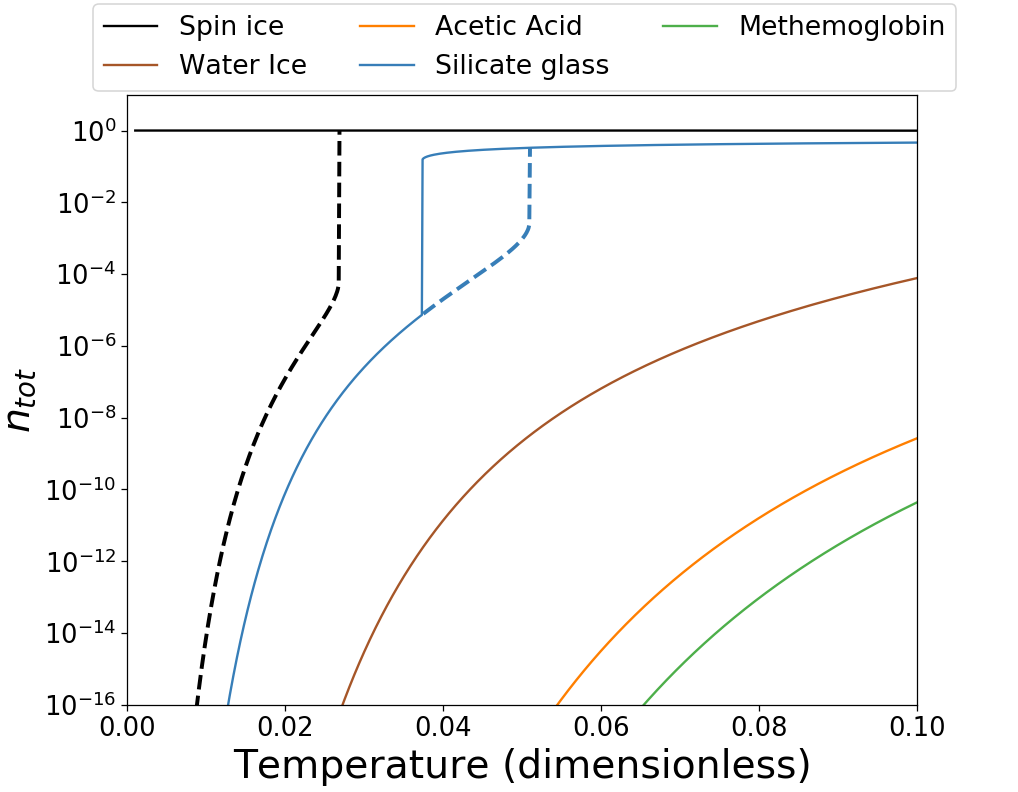

material carrier density natural units comparison marker PAPER dimensionless markerless.png


In [25]:
###monopole density against temperature###
graph1= plt.figure(figsize=(9,7))

plt.plot(TempArray_double1[0:262], nArray_double1[0:262] + n_2Array_double1[0:262], 'k--', linewidth=2.5) #, label="$\mu=1.00$ Spin ice")
#plt.plot(TempArray_double2[0:1000], nArray_double2[0:1000] + n_2Array_double2[0:1000], color='slategrey', linestyle='--', linewidth=2.5) #, label="Water Ice")
#plt.plot(TempArray_double3[0:1000], nArray_double3[0:1000] + n_2Array_double3[0:1000], 'c--', linewidth=2.5) #, label="Pure Water")
#plt.plot(TempArray_double4[0:1000], nArray_double4[0:1000] + n_2Array_double4[0:1000], 'y--', linewidth=2.5) #, label="Acetic Acid")
#plt.plot(TempArray_double5[0:1000], nArray_double5[0:1000] + n_2Array_double5[0:1000], 'g--', linewidth=2.5) #, label="AOT in cyclohexane")
#plt.plot(TempArray_double6[0:1000], nArray_double6[0:1000] + n_2Array_double6[0:1000], 'm--', linewidth=2.5) #, label="Phosphoric Acid")
plt.plot(TempArray_double7[305:456], nArray_double7[305:456] + n_2Array_double7[305:456], color='#377eb8', linestyle='--', linewidth=2.5) #, label="Silicate glass")
#plt.plot(TempArray_double8[0:1000], nArray_double8[0:1000] + n_2Array_double8[0:1000], 'r--', linewidth=2.5) #, label="Methemoglobin")

plt.plot(TempArray_double1[1001:2000], nArray_double1[1001:2000] + n_2Array_double1[1001:2000], 'k-', label="Spin ice")
plt.plot(TempArray_double2[1001:2000], nArray_double2[1001:2000] + n_2Array_double2[1001:2000], color='#a65628', linestyle='-', label="Water Ice")
#plt.plot(TempArray_double3[1001:2000], nArray_double3[1001:2000] + n_2Array_double3[1001:2000], 'c-', label="Pure Water")
plt.plot(TempArray_double4[1001:2000], nArray_double4[1001:2000] + n_2Array_double4[1001:2000], color='#ff7f00', linestyle='-', label="Acetic Acid")
#plt.plot(TempArray_double5[1001:2000], nArray_double5[1001:2000] + n_2Array_double5[1001:2000], 'g-', label="AOT in cyclohexane")
#plt.plot(TempArray_double6[1001:2000], nArray_double6[1001:2000] + n_2Array_double6[1001:2000], 'm-', label="Anhydrous Orthophosphoric Acid")
plt.plot(TempArray_double7[1001:2000], nArray_double7[1001:2000] + n_2Array_double7[1001:2000], color='#377eb8', linestyle='-', label="Silicate glass")
plt.plot(TempArray_double8[1001:2000], nArray_double8[1001:2000] + n_2Array_double8[1001:2000], color='#4daf4a', linestyle='-', label="Methemoglobin")


plt.xlabel("Temperature (dimensionless)", size=25)
plt.ylabel("$n_{tot}$", size=25)
plt.yscale('log')
#plt.xscale('log')
plt.ylim(10**-16,10)
plt.xlim(0,0.1)
#plt.title(str(factor) + " factor double model monopole densities against temperature", size=20)
#plt.title("Material carrier density against temperature", size=20)

lgd = plt.legend(bbox_to_anchor=(-0.06, 1.17), ncol=3 ,loc='upper left', fontsize=17)
plt.xticks(fontsize=16.5)
plt.yticks(fontsize=16.5)

#lgd = plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=15)

#plt.gcf().canvas.draw()
#invFigure = plt.gcf().transFigure.inverted()

#lgd_pos = lgd.get_window_extent()
#lgd_coord = invFigure.transform(lgd_pos)
#lgd_xmax = lgd_coord[1, 0]

#ax_pos = plt.gca().get_window_extent()
#ax_coord = invFigure.transform(ax_pos)
#ax_xmax = ax_coord[1, 0]

#shift = 1 - (lgd_xmax - ax_xmax)
#plt.gcf().tight_layout(rect=(0, 0, 1.48*shift, 1))

#graph_string = ' factor monopole densities against temperature double model hysterisis.png'
#filename = factor_string + graph_string
filename = "material carrier density natural units comparison marker PAPER dimensionless markerless.png"
print(filename)
plt.savefig(filename)

In [22]:
###### OLD #######
def double_monopole_natural(start_mu, coupling, switch, hysteresis, start_T, num_T, T_max, lattice_parameter, charge, relative_permittivity, site_volume, tol, limit, logTemp=True, nat_units=False, electric=False ,n_init=0, n_init2=1):

    mu_0 = 4 * mp.pi * 10**-7 #vacuum permeability
    epsilon_0 = 8.854 * 10**-12
    a = lattice_parameter #lattice spacing of diamond lattice
    Q = charge #magnetic charge
    vol_per_site = site_volume
    N_0 = 6.02214 * 10**23 #Total number of site, avagadro's number
    k_B = 1.38064852 * 10**-23 #Boltzmann constant
    T = start_T #Temperature in Kelvins (parameter)
    epsilon_r = relative_permittivity
    
    if nat_units == True and electric == False:
        U_0 = (Q**2 * mu_0 * epsilon_r)/(4 * mp.pi * a) #reduction factor for natural units
    elif nat_units == True and electric == True:
        U_0 = (Q**2)/(4 * mp.pi * epsilon_0 * epsilon_r * a) #reduction factor for natural units
    else:
        U_0 = 1
    
    ##array initialisation##
    
    if logTemp == True:
        TempArray_double = np.geomspace(start_T, T_max, num=num_T)
    else:
        TempArray_double = np.linspace(start_T, T_max, num=num_T)
    
    SpecHeatArray_double = []
    EntropyArray = []
    muDoubleArray = []
    mu2DoubleArray = []
    nArray = []
    n_2Array = []
    internalEnergyArray = []
    
    ##hysteresis modification##
    if hysteresis == True:
        #appends a reversed TempArray onto the original TempArray
        TempArray_double = np.append(TempArray_double, np.flip(TempArray_double), axis=0)
        num_T = num_T * 2 # correcting the number of T points to match TempArray number of elements
        
    ##natural units 
    if nat_units == True:
        T = T/U_0
        TempArray_double = (TempArray_double)/U_0
        start_mu = start_mu/U_0
    
    j=0 #variable to cycle through elements of TempArray
    
    old_mu = 0
    new_mu = -start_mu * k_B
    init_mu = -start_mu * k_B
    old_mu_2 = 0
    new_mu_2 = -start_mu * coupling * k_B
    init_mu_2 = -start_mu * coupling * k_B
    
    #while T <= T_max :
    while j < num_T :
        
        i = 0
        old_mu = 0
        old_mu_2 = 0
        #note older versions had lines here that reset the new_mu values
        #this would stop previous temperature steps affecting subsequent ones
        #thus stopping any hysteresis
        beta = 1/(k_B * T)
        
        if electric == True:
            l_T = (Q * Q)/(k_B * T * U_0 * 8 * np.pi * epsilon_0 * epsilon_r)
        else:
            l_T = (mu_0 * epsilon_r * Q * Q)/(k_B * T * U_0 * 8 * np.pi) #Bjerrum length
        #print("Temperature:", T)
        
        
        while np.abs((new_mu - old_mu)/new_mu) > tol and i < limit :
            #print("new mu:", new_mu)
            #print("new mu2:", new_mu_2)
            old_mu = new_mu #if new and old values not close enough, new replaces old
            old_mu_2 = new_mu_2
            #new number of monopoles
            n = (4/3 * mp.exp(beta * old_mu))/(1 +(1/3 * ( 4 * mp.exp(beta * old_mu) + mp.exp(beta * old_mu_2))))
            n_2 = (1/3 * mp.exp(beta * old_mu_2))/(1 +(1/3 * ( 4 * mp.exp(beta * old_mu) + mp.exp(beta * old_mu_2))))
            #print("n:", n)
            
            #calculating new charge densities
            ##this 'if' statement switches on (switch=True) and off (switch=False) metastability
            ###As such hysteresis will not occur if this switch=False
            if i == 0 and switch == False:
                #print("metastability on")
                rho = n_init/vol_per_site
                rho_2 = n_init2/vol_per_site
                
            else:
                rho = n/vol_per_site
                rho_2 = n_2/vol_per_site
                
            rho_I = rho + 4*rho_2
            #print("rho:", rho)
            
            if electric == True:
                l_D = np.sqrt((k_B * T * U_0 * epsilon_0 * epsilon_r)/(Q * Q * rho_I)) #Debye length Calc
            else:
                l_D = np.sqrt((k_B * T * U_0)/(Q * Q * rho_I * mu_0 * epsilon_r))
            #print("l_D: ", l_D)
            #print("l_T:", l_T)
            
            deltaDH = k_B * T * ((l_T)/(l_D + a))
            new_mu = init_mu + deltaDH
            new_mu_2 = init_mu_2 + 4*deltaDH
            #print("deltaDH:",deltaDH)
            #print("mu:", new_mu)
            #print("mu_2:", new_mu_2)
            #print(old_mu)
            #print(np.abs(new_mu - old_mu))
            #print("")
            
            i += 1
            if i==limit:
                print('Warning: Monopole density did not converge after', limit, 'iterations!')
                # This stops the function running forever if there is a problem with convergence.
        
        ##Calculates the differential of monopole density n wit respect to Temperature, used to calculate specific heat
        #differential = mp.diff(lambda t:((4/3 * mp.exp((1/(k_B * t)) * old_mu))/(1 +(1/3 * ( 4 * mp.exp((1/(k_B * t)) * old_mu) + mp.exp((1/(k_B * t)) * old_mu_2) )))), T)
        #differential_2 = mp.diff(lambda t:((1/3 * mp.exp((1/(k_B * t)) * old_mu_2))/(1 +(1/3 * ( 4 * mp.exp((1/(k_B * t)) * old_mu) + mp.exp((1/(k_B * t)) * old_mu_2) )))), T)
        
        #dn/dT calculations, long because of the equations being self-consistent
        differential = mp.diff(lambda t:((1/3 * 4 * mp.exp((1/(k_B * t)) * (init_mu + k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a))) ))/(1 +(1/3 * ( (4 * mp.exp((1/(k_B * t)) * (init_mu + k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a))))) + mp.exp((1/(k_B * t)) * (init_mu_2 + coupling * k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a)))) ) ))), T)
        differential_2 = mp.diff(lambda t:((1/3 * mp.exp((1/(k_B * t)) * (init_mu_2 + coupling * k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a)))))/(1 +(1/3 * ( 4 * mp.exp((1/(k_B * t)) * (init_mu + k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a)))) + mp.exp((1/(k_B * t)) * (init_mu_2 + coupling * k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a)))) )))), T)
        
        SpecHeatVal = - N_0 * (new_mu * float(differential) + new_mu_2 * float(differential_2))
        #print("differential of n wrt T:", differential)
        #print("differential of n_2 wrt T:", differential_2)
        #print("Specific Heat Value:", SpecHeatVal)
        
        Entropy = - k_B * N_0 *( (n*mp.log(n/2) + (n_2*mp.log(2*n_2) + ((1-n-n_2)*mp.log(1-n-n_2)) + ((1-n-n_2)*mp.log(2/3)) ) ) )
        #Entropy_corrected = Entropy - (8.314 * 1/2*np.log(3/2))
        
        if Entropy < 0:
            Entropy = 0
        
        internalEnergyTerm = mp.log(1+(a/l_D)) - (a/l_D) + 1/2*((a/l_D)**2)
        #internalEnergyTerm = np.log(1+(a/np.sqrt((k_B*T)/(Q*Q*n/vol_per_site*mu_0)))) - (a/np.sqrt((k_B*T)/(Q * Q * n/vol_per_site * mu_0))) + 1/2*((a/np.sqrt((k_B * T)/(Q * Q * n/vol_per_site * mu_0)))**2)
        internalEnergy = - ((4 * N_0 * k_B * T)/(6*mp.pi*mp.sqrt(3))) * internalEnergyTerm
        
        nArray = np.append(nArray, n)
        n_2Array = np.append(n_2Array, n_2)
        muDoubleArray = np.append(muDoubleArray, new_mu)
        mu2DoubleArray = np.append(mu2DoubleArray, new_mu_2)
        EntropyArray = np.append(EntropyArray, Entropy)
        internalEnergyArray = np.append(internalEnergyArray, internalEnergy)
        #TempArray_double = np.append(TempArray_double, T)
        SpecHeatArray_double = np.append(SpecHeatArray_double, SpecHeatVal)
        
        #T += T_step
        
        j += 1
        if j < num_T :
            T = TempArray_double[j]
        #print("done")
        
    Omega = internalEnergyArray - (init_mu * (N_0*nArray)) - (init_mu_2 * (N_0*n_2Array)) - (TempArray_double*EntropyArray)
    
    #converts chemical potentials and temperatures from natural to SI units
    if nat_units == True:
        Nat_TempArray_double = TempArray_double 
        Nat_muDoubleArray = muDoubleArray
        Nat_mu2DoubleArray = mu2DoubleArray
        TempArray_double = (Nat_TempArray_double*U_0)
        muDoubleArray = Nat_muDoubleArray*U_0
        mu2DoubleArray = Nat_mu2DoubleArray*U_0
        print("")
        print("natural units final")
        #print("Temperature values:", TempArray_double)
        #print("Specific Heat array:", SpecHeatArray_double)
        return (TempArray_double, SpecHeatArray_double, EntropyArray, muDoubleArray, mu2DoubleArray, nArray, n_2Array, Omega, Nat_TempArray_double, Nat_muDoubleArray, Nat_mu2DoubleArray)
    else:
        print("")
        print("SI units only final")
        #print("Temperature values:", TempArray_double)
        #print("Specific Heat array:", SpecHeatArray_double)
        return (TempArray_double, SpecHeatArray_double, EntropyArray, muDoubleArray, mu2DoubleArray, nArray, n_2Array, Omega)

In [15]:
#sanity 1
TempArray_double_san1, SpecHeatArray_double_san1, EntropyArray_double_san1, muDoubleArray_san1, mu2DoubleArray_san1, nArray_double_san1, n_2Array_double_san1, Omega_double_san1, sanity_san1 = double_monopole_magnetic_SI(1.00, 4, True, hysteresis_switch, 0.001, 200, 10, DTt_a, DTt_Q, DTt_epsilon_r, DTt_vol_per_site, 1e-4, 1000, True)



SI units final


In [16]:
#sanity 2
TempArray_double_san2, SpecHeatArray_double_san2, EntropyArray_double_san2, muDoubleArray_san2, mu2DoubleArray_san2, nArray_double_san2, n_2Array_double_san2, Omega_double_san2, sanity_san2 = double_monopole_magnetic_SI(1.57, 4, True, hysteresis_switch, 0.001, 200, 10, DTt_a, DTt_Q, DTt_epsilon_r, DTt_vol_per_site, 1e-4, 1000, True)



SI units final


In [17]:
#sanity 3
TempArray_double_san3, SpecHeatArray_double_san3, EntropyArray_double_san3, muDoubleArray_san3, mu2DoubleArray_san3, nArray_double_san3, n_2Array_double_san3, Omega_double_san3, sanity_san3 = double_monopole_magnetic_SI(2.5, 4, True, hysteresis_switch, 0.001, 200, 10, DTt_a, DTt_Q, DTt_epsilon_r, DTt_vol_per_site, 1e-4, 1000, True)



SI units final


In [18]:
#sanity 4
TempArray_double_san4, SpecHeatArray_double_san4, EntropyArray_double_san4, muDoubleArray_san4, mu2DoubleArray_san4, nArray_double_san4, n_2Array_double_san4, Omega_double_san4, sanity_san4 = double_monopole_magnetic_SI(4.34, 4, True, hysteresis_switch, 0.001, 200, 10, DTt_a, DTt_Q, DTt_epsilon_r, DTt_vol_per_site, 1e-4, 1000, True)



SI units final


In [19]:
#sanity 5
TempArray_double_san5, SpecHeatArray_double_san5, EntropyArray_double_san5, muDoubleArray_san5, mu2DoubleArray_san5, nArray_double_san5, n_2Array_double_san5, Omega_double_san5, sanity_san5 = double_monopole_magnetic_SI(1.30, 4, True, hysteresis_switch, 0.001, 200, 10, DTt_a, DTt_Q, DTt_epsilon_r, DTt_vol_per_site, 1e-4, 1000, True)



SI units final


In [21]:
#sanity GLASS
TempArray_double_glass, SpecHeatArray_double_glass, EntropyArray_double_glass, muDoubleArray_glass, mu2DoubleArray_glass, nArray_double_glass, n_2Array_double_glass, Omega_double_glass, sanity_glass = double_monopole_electrolyte_SI(NCSO_mu, factor, True, hysteresis_switch, 50, 200, 300, 1*NCSO_a, 1*NCSO_Q, NCSO_epsilon_r, NCSO_vol_per_site, 1e-4, 1000, False)
#2.2a 0.85q


SI units final


<IPython.core.display.Javascript object>


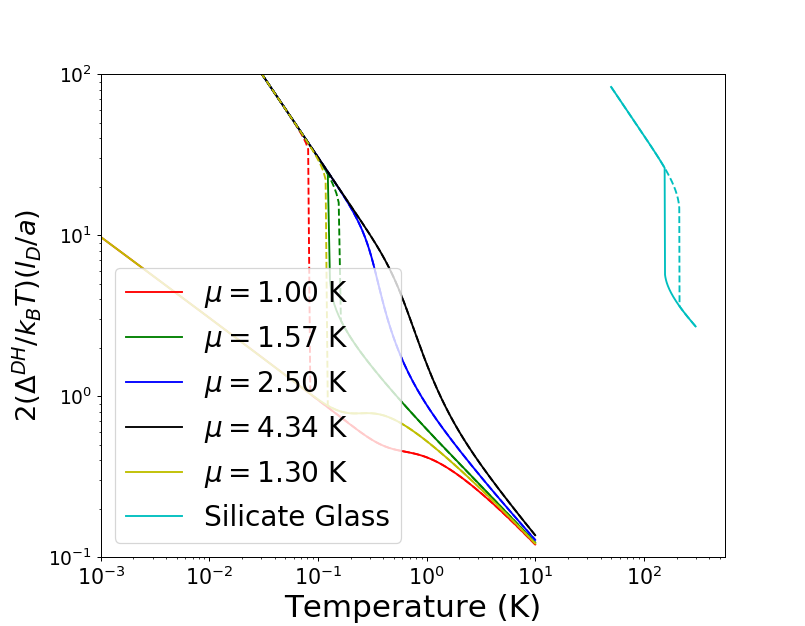

(0.001, 563.6082186518637)

In [22]:
plt.figure(figsize=(9,7))

plt.plot(TempArray_double_san1[0:200], sanity_san1[0:200], 'r--')
plt.plot(TempArray_double_san1[200:400], sanity_san1[200:400], 'r', label="$\mu=1.00$ K")

plt.plot(TempArray_double_san2[0:200], sanity_san2[0:200], 'g--')
plt.plot(TempArray_double_san2[200:400], sanity_san2[200:400], 'g', label="$\mu=1.57$ K")

#plt.plot(TempArray_double_san2[0:200], nArray_double_san2[0:200]+n_2Array_double_san2[0:200], 'm--')
#plt.plot(TempArray_double_san2[200:400], nArray_double_san2[200:400]+n_2Array_double_san2[200:400], 'm', label="$\mu = 1.57$ K monopole density")


plt.plot(TempArray_double_san3[0:200], sanity_san3[0:200], 'b--')
plt.plot(TempArray_double_san3[200:400], sanity_san3[200:400], 'b', label="$\mu=2.50$ K")

plt.plot(TempArray_double_san4[0:200], sanity_san4[0:200], 'k--')
plt.plot(TempArray_double_san4[200:400], sanity_san4[200:400], 'k', label="$\mu=4.34$ K")

plt.plot(TempArray_double_san5[0:200], sanity_san5[0:200], 'y--')
plt.plot(TempArray_double_san5[200:400], sanity_san5[200:400], 'y', label="$\mu=1.30$ K")

plt.plot(TempArray_double_glass[0:200], sanity_glass[0:200], 'c--')
plt.plot(TempArray_double_glass[200:400], sanity_glass[200:400], 'c', label="Silicate Glass")

#plt.plot(TempArray_double_glass[0:200], nArray_double_glass[0:200]+n_2Array_double_glass[0:200], 'm--')
#plt.plot(TempArray_double_glass[200:400], nArray_double_glass[200:400]+n_2Array_double_glass[200:400], 'm', label="Silicate Glass monopole density")


plt.xscale('log')
plt.yscale('log')

plt.legend(loc='lower left', fontsize=22.5)

plt.xticks(fontsize=16.5)
plt.yticks(fontsize=15)

plt.ylabel("$2(\Delta^{DH}/k_{B}T)(l_{D}/a)$", size=22) #\Delta^{DH}
plt.xlabel("Temperature (K)", size=25)


plt.ylim(10**-1, 10**2)
plt.xlim(10**-3)

#plt.savefig("2(DeltaDH_over_kt)(l_D_over_a).pdf")

In [19]:
print(TempArray_double_glass[200:400])

[190.04004004 190.24024024 190.44044044 190.64064064 190.84084084
 191.04104104 191.24124124 191.44144144 191.64164164 191.84184184
 192.04204204 192.24224224 192.44244244 192.64264264 192.84284284
 193.04304304 193.24324324 193.44344344 193.64364364 193.84384384
 194.04404404 194.24424424 194.44444444 194.64464464 194.84484484
 195.04504505 195.24524525 195.44544545 195.64564565 195.84584585
 196.04604605 196.24624625 196.44644645 196.64664665 196.84684685
 197.04704705 197.24724725 197.44744745 197.64764765 197.84784785
 198.04804805 198.24824825 198.44844845 198.64864865 198.84884885
 199.04904905 199.24924925 199.44944945 199.64964965 199.84984985
 200.05005005 200.25025025 200.45045045 200.65065065 200.85085085
 201.05105105 201.25125125 201.45145145 201.65165165 201.85185185
 202.05205205 202.25225225 202.45245245 202.65265265 202.85285285
 203.05305305 203.25325325 203.45345345 203.65365365 203.85385385
 204.05405405 204.25425425 204.45445445 204.65465465 204.85485485
 205.05505